In [ ]:
%pip install pandas
%pip install matplotlib
%pip install openpyxl
%pip install scipy
%pip install statsmodels

In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

df = pd.read_excel('./italy_values_dataset.xlsx')
df_livestock = (
    df[df["Indicator Name"] == "Livestock production index (2014-2016 = 100)"]
    .melt(id_vars=["Indicator Name"], var_name="Year", value_name="Value")
    .assign(Year=lambda d: d["Year"].astype(int))
    .dropna(subset=["Value"])
    [["Year", "Value"]]
    .reset_index(drop=True)
)
df_livestock.head()

,Year,Value
0,1961,70.91
1,1962,72.59
2,1963,65.95
3,1964,69.57
4,1965,72.80


Text(0.5, 1.0, 'Livestock Production Index Over Years 1961-2022')

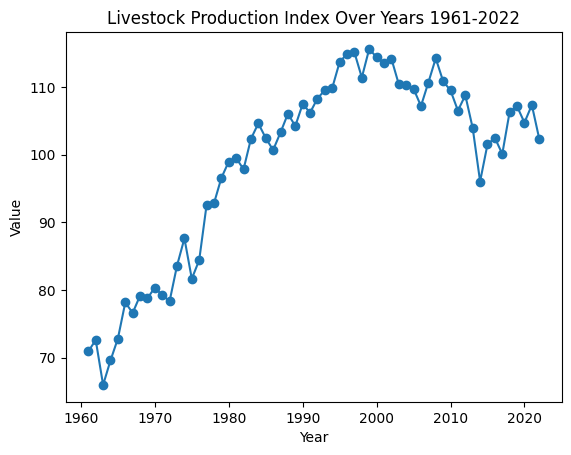

In [3]:
fig, ax = plt.subplots()
ax.plot(df_livestock['Year'], df_livestock['Value'], marker='o', linestyle='-')
ax.set_xlabel("Year")
ax.set_ylabel("Value")
ax.set_title("Livestock Production Index Over Years 1961-2022")

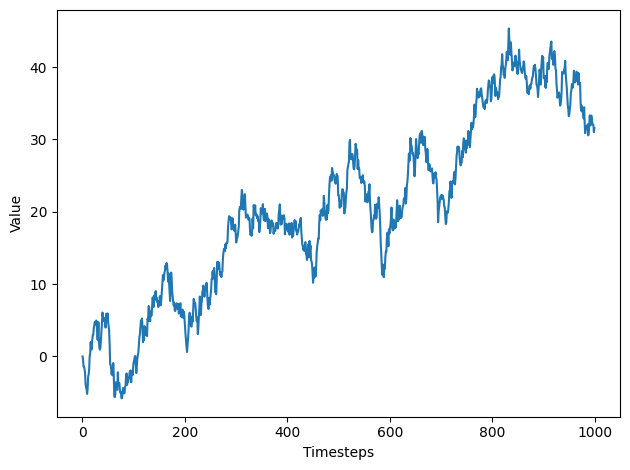

In [4]:
np.random.seed(9)
steps = np.random.standard_normal(1000)
steps[0] = 0
random_walk = np.cumsum(steps)

fig, ax = plt.subplots()
ax.plot(random_walk)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')
plt.tight_layout()

mean 57    102.963333
58    104.516667
59    106.063333
60    106.396667
61    104.800000
Name: Value, dtype: float64
variance 57     9.916933
58    14.856533
59     1.493333
60     2.093333
61     6.228700
Name: Value, dtype: float64
Serie non stazionaria (p-value: 0.064)


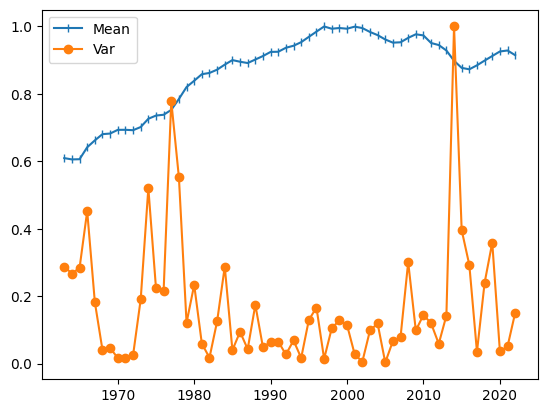

In [5]:
# TESTING FOR STATIONARITY
def is_stationary(df_livestock):
    values = df_livestock['Value']
    rolling_mean = values.rolling(3).mean()
    rolling_var = values.rolling(3).var()
    print("mean", rolling_mean.tail())
    print("variance", rolling_var.tail())
    ADF_result = adfuller(values)
    if (ADF_result[1] < 0.05):
        print(f"Serie stazionaria (p-value: {ADF_result[1]:.2})")
    else: print(f"Serie non stazionaria (p-value: {ADF_result[1]:.2})")
    fig, ax = plt.subplots()
    ax.plot(df_livestock['Year'], rolling_mean/rolling_mean.max(), marker='|', label='Mean')
    ax.plot(df_livestock['Year'], rolling_var/rolling_var.max(), marker = 'o', label='Var')    
    ax.legend(loc=2)
is_stationary(df_livestock)

   Year  Value  Diff
0  1961  70.91   NaN
1  1962  72.59  1.68
2  1963  65.95 -6.64
3  1964  69.57  3.62
4  1965  72.80  3.23
ADF statistic: -4.045587586051285
p-value: 0.001189740551875537


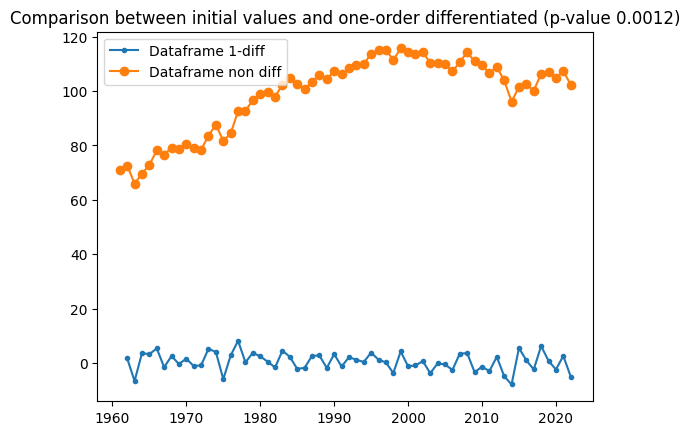

In [ ]:
# prima differenziazione per fare in modo che rimanga costante nel tempo = diventi stazionaria
df_livestock['Diff'] = df_livestock['Value'].diff()
print(df_livestock.head())

ADF_result = adfuller(df_livestock['Diff'].dropna())
print("ADF statistic:", ADF_result[0])
print("p-value:", ADF_result[1])

# plot
fig, ax = plt.subplots()
ax.plot(df_livestock['Year'], df_livestock['Diff'], label='Dataframe 1-diff', marker='.')
ax.plot(df_livestock['Year'], df_livestock['Value'], label='Dataframe non diff', marker='o')
ax.set_title(f"Comparison between initial values and one-order differentiated (p-value {ADF_result[1]:.2})") 
ax.legend(loc=2)

ADF Statistic prima di differenziazione: -2.764199820687294
p-value prima di differenziazione: 0.0635723285140925


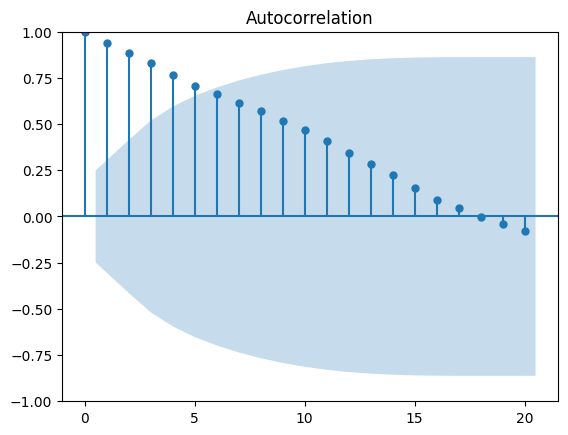

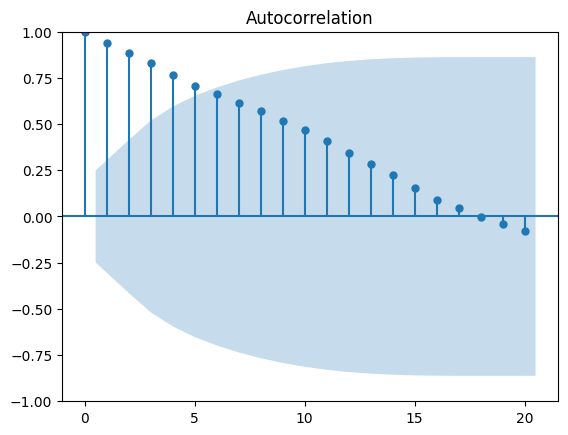

In [8]:
ADF_result = adfuller(df_livestock['Value'])
print(f'ADF Statistic prima di differenziazione: {ADF_result[0]}')
print(f'p-value prima di differenziazione: {ADF_result[1]}')
plot_acf(df_livestock['Value'], lags=20)

1    1.68
2   -6.64
3    3.62
4    3.23
5    5.34
Name: Diff, dtype: float64
ADF Statistic dopo differenziazione: -4.045587586051285
p-value dopo differenziazione: 0.001189740551875537


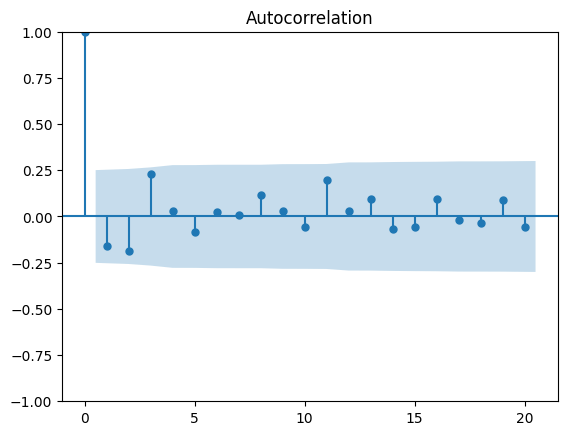

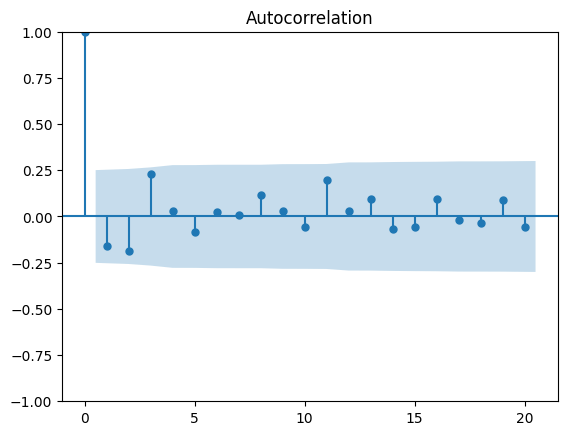

In [26]:
diff_values = df_livestock['Diff'].dropna()
print(diff_values.head())

ADF_result = adfuller(diff_values)
print(f'ADF Statistic dopo differenziazione: {ADF_result[0]}')
print(f'p-value dopo differenziazione: {ADF_result[1]}')

plot_acf(diff_values, lags=20)

Text(0, 0.5, 'Value')

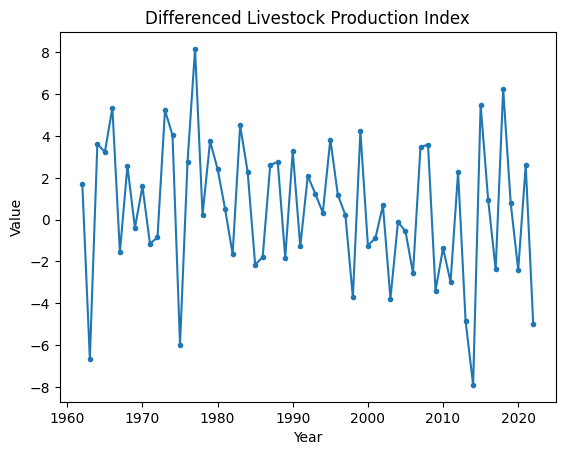

In [36]:
fig, ax = plt.subplots()
ax.plot(df_livestock['Year'], df_livestock['Diff'], marker='.')
ax.set_title("Differenced Livestock Production Index")
ax.set_xlabel("Year")
ax.set_ylabel("Value")

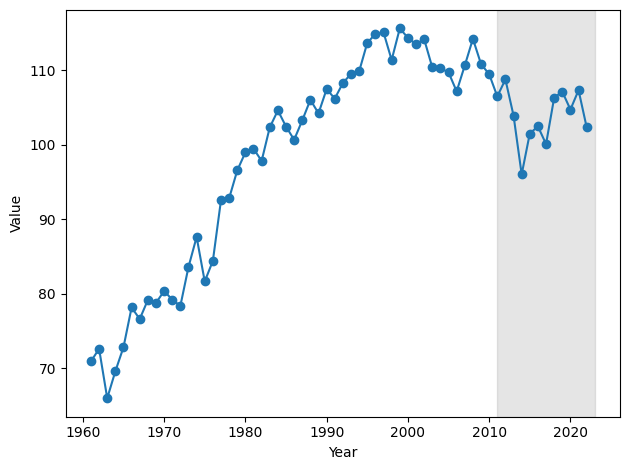

In [45]:
train = df_livestock[:50]
test = df_livestock[50:]
fig, ax = plt.subplots()

ax.plot(df_livestock['Year'], df_livestock['Value'], marker="o", linestyle="-")
ax.set_xlabel('Year')
ax.set_ylabel('Value')
ax.axvspan(2011, 2023, color='#808080', alpha=0.2)

plt.tight_layout()

In [61]:
mean = np.mean(train['Value'])
test['pred_mean'] = mean

first_value = train.iloc[0]['Value']
last_value = train.iloc[-1]['Value']

test['pred_last'] = last_value

deltaY = last_value - first_value     # ultimo valore - primo valore
deltaX = len(train)-1                 # numero valutazioni nel training set - 1
drift = deltaY / deltaX

x_vals = np.arange(1, len(test) + 1)
pred_drift = drift * x_vals + first_value
test['pred_drift'] = pred_drift
test.head()
test.copy()

C:\Users\oldan\AppData\Local\Temp\ipykernel_13040\1162790020.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred_mean'] = mean
C:\Users\oldan\AppData\Local\Temp\ipykernel_13040\1162790020.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred_last'] = last_value
C:\Users\oldan\AppData\Local\Temp\ipykernel_13040\1162790020.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

,Year,Value,Diff,pred_mean,pred_last,pred_drift
50,2011,106.50,-2.98,97.565,109.48,71.697143
51,2012,108.77,2.27,97.565,109.48,72.484286
52,2013,103.92,-4.85,97.565,109.48,73.271429
53,2014,96.02,-7.90,97.565,109.48,74.058571
54,2015,101.51,5.49,97.565,109.48,74.845714
55,2016,102.47,0.96,97.565,109.48,75.632857
56,2017,100.09,-2.38,97.565,109.48,76.420000
57,2018,106.33,6.24,97.565,109.48,77.207143
58,2019,107.13,0.80,97.565,109.48,77.994286
59,2020,104.73,-2.40,97.565,109.48,78.781429


In [64]:
import statsmodels.api as sm
t = np.arange(len(train))  # 0,1,2,...
X = sm.add_constant(t)
y = train['Value'].values
model = sm.OLS(y, X).fit()
slope = model.params[1]
print(model.summary())  # vedi p-value, conf_int, R^2

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     322.9
Date:                Mon, 20 Oct 2025   Prob (F-statistic):           5.98e-23
Time:                        11:33:17   Log-Likelihood:                -155.54
No. Observations:                  50   AIC:                             315.1
Df Residuals:                      48   BIC:                             318.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         73.6592      1.544     47.705      0.0

colonne Index(['Year', 'Value', 'Diff', 'pred_mean', 'pred_last', 'pred_drift'], dtype='object')


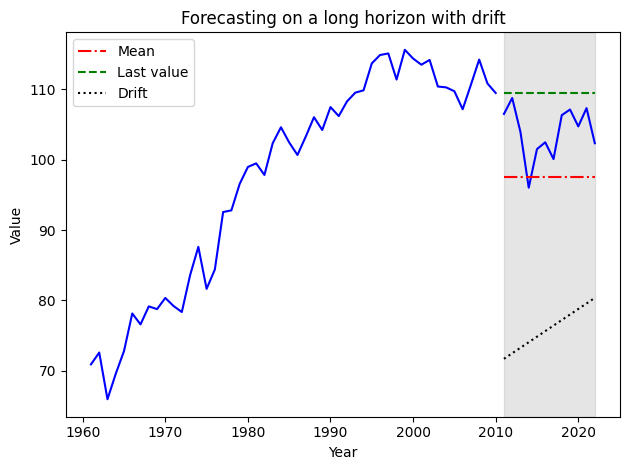

In [60]:
fig, ax = plt.subplots()
print("colonne", test.columns)

ax.plot(train['Year'], train['Value'], 'b-')
ax.plot(test['Year'], test['Value'], 'b-')
ax.plot(test['Year'], test['pred_mean'], 'r-.', label='Mean')
ax.plot(test['Year'], test['pred_last'], 'g--', label='Last value')
ax.plot(test['Year'], test['pred_drift'], 'k:', label='Drift')

ax.axvspan(2011, 2022, color='#808080', alpha=0.2)
ax.legend(loc=2)

ax.set_xlabel('Year')
ax.set_ylabel('Value')
ax.set_title('Forecasting on a long horizon with drift')

plt.tight_layout()

mi sa che questo grafico sopra è sbagliato, il drift dovrebbe stare più in alto, iniziare dall'ultimo punto del training set, non so